In [56]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [57]:
batch_size = 128
nb_classes = 10

img_cols, img_rows = 28, 28

(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X = np.concatenate([X, X_test], axis=0)
y = np.concatenate([y, y_test], axis=0)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

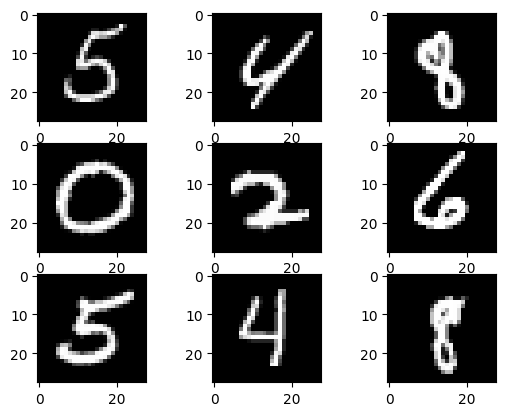

In [58]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1).astype('float32') / 255.0
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1).astype('float32') / 255.0
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1).astype('float32') / 255.0

y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
y_val = tf.keras.utils.to_categorical(y_val, nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, nb_classes)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i], cmap='gray')

plt.show()

In [59]:
def residual_block(X, filters, downsample=False):
    X_shortcut = X

    if downsample:
        strides = 2
        X_shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='valid')(X_shortcut)
        X_shortcut = BatchNormalization()(X_shortcut)
    else:
        strides = 1
    
    X = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [60]:
def ResNet18(input_shape, nb_classes):
    X_input = Input(input_shape)

    X = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = residual_block(X, 64)
    X = residual_block(X, 64)
    
    X = residual_block(X, 128, downsample=True)
    X = residual_block(X, 128)

    X = residual_block(X, 256, downsample=True)
    X = residual_block(X, 256)
    
    X = residual_block(X, 512, downsample=True)
    X = residual_block(X, 512)

    X = GlobalAveragePooling2D()(X)
    X = Dense(nb_classes, activation='softmax')(X)

    model = tf.keras.models.Model(inputs=X_input, outputs=X)
    return model

In [61]:
model = ResNet18(input_shape=(img_rows, img_cols, 1), nb_classes=nb_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_123 (Conv2D)         (None, 14, 14, 64)           3200      ['input_11[0][0]']            
                                                                                                  
 batch_normalization_123 (B  (None, 14, 14, 64)           256       ['conv2d_123[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_105 (Activation  (None, 14, 14, 64)           0         ['batch_normalization_12

In [63]:
EPOCHS = 30
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, validation_data=(X_val, y_val))

score = model.evaluate(X_test, y_test)

print(f'Test score: {score[0]}')
print(f'Test Accuracy: {score[1]}')

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.ylabel("Predection: ".format(predicted_labels[i]), fontsize=18)

plt.show()

Epoch 1/30
438/438 [==============================] - 1105s 3s/step - loss: 0.0748 - accuracy: 0.9778 - val_loss: 0.3974 - val_accuracy: 0.8937
Epoch 2/30
438/438 [==============================] - 1131s 3s/step - loss: 0.0468 - accuracy: 0.9862 - val_loss: 0.1050 - val_accuracy: 0.9720
Epoch 3/30
438/438 [==============================] - 1108s 3s/step - loss: 0.0350 - accuracy: 0.9894 - val_loss: 0.0613 - val_accuracy: 0.9834
Epoch 4/30
 88/438 [=====>........................] - ETA: 15:17 - loss: 0.0301 - accuracy: 0.9901

KeyboardInterrupt: 